In [1]:
!gpustat

121.pami.group     Tue Jul 18 16:56:40 2023  455.32.00
[0] A100-PCIE-40GB | 41°C,  61 % | 20073 / 40536 MB | zzhuang(?M) zzhuang(?M) zzhuang(20071M)
[1] A100-PCIE-40GB | 28°C,   0 % |     2 / 40536 MB | zzhuang(?M) zzhuang(?M)
[2] A100-PCIE-40GB | 28°C,   0 % | 12332 / 40536 MB | zzhuang(6183M) zzhuang(6147M)
[3] A100-PCIE-40GB | 29°C,   0 % |     2 / 40536 MB | zzhuang(?M) zzhuang(?M)


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import sys
import matplotlib
sys.path.insert(0, '/home/zzhuang/AdaTrans')
sys.path.insert(0, '/home/zzhuang/AdaTrans/models/stylegan2')
torch.cuda.set_device(3)
torch.autograd.set_grad_enabled(False)
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import torch.distributions as D
torch.set_printoptions(precision=3)
torch.set_printoptions(sci_mode=False)
import torchvision.transforms as transforms
from models.ops import dataset_with_indices
from models.ops import load_network, age2group
from models.ops.loggerx import LoggerX
from models.ops.grad_scaler import NativeScalerWithGradNormCount
from models.decoder import StyleGANDecoder
from models.e4e.psp_encoders import Encoder4Editing
from models.modules import Classifier
%matplotlib inline

In [3]:
img_size = 256
bs = 64
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    normalize
])
test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    normalize
])


from models.dataset import dataset_dict

data_root = '/home/zzhuang/DATASET/celeba/img_align_celeba_ffhq'
dataset_type = dataset_dict['CelebA']
test_celeba_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='test', transform=test_transform),
    batch_size=bs,
    shuffle=False,
    num_workers=8)
train_celeba_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='train', transform=train_transform),
    batch_size=bs,
    shuffle=True,
    drop_last=True,
    num_workers=8)
mem_celeba_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='train', transform=test_transform),
    batch_size=bs,
    num_workers=8)

data_root = '/home/zzhuang/DATASET/celeba-hq/celeba-256_ffhq'
test_celebahq_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='test', transform=test_transform),
    batch_size=bs,
    shuffle=False,
    num_workers=8)
train_celebahq_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='train', transform=train_transform),
    batch_size=bs,
    shuffle=True,
    drop_last=True,
    num_workers=8)
mem_celebahq_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='train', transform=test_transform),
    batch_size=bs,
    num_workers=8)

data_root = '/home/zzhuang/DATASET/FFHQ/images256x256'
dataset_type = dataset_dict['FFHQAge']
train_ffhq_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='train', transform=train_transform),
    batch_size=bs,
    shuffle=True,
    drop_last=True,
    num_workers=8)
test_ffhq_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='test', transform=test_transform),
    batch_size=bs,
    shuffle=False,
    num_workers=8)
mem_ffhq_loader = torch.utils.data.DataLoader(
    dataset_type(data_root, img_size=img_size, split='train', transform=test_transform),
    batch_size=bs,
    num_workers=8)

# Train the classifier

In [10]:
# Binary Classifier
# backbone = 'r50'
backbone = 'r34'
image_classifier = Classifier(backbone).cuda()
optimizer = torch.optim.Adam(image_classifier.parameters(), lr=0.0001, weight_decay=0.000)
logger = LoggerX(save_root=None, print_freq=100, enable_wandb=False)

n_iter = 1
for epoch in range(10):
    for images, labels in train_celeba_loader:
        images, labels = images.cuda(), labels.cuda()
        image_classifier.train()

        with torch.autograd.set_grad_enabled(True):
            outs = image_classifier.forward_attr(images)[0]
            loss = F.binary_cross_entropy_with_logits(outs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        logger.msg([loss, ], n_iter)
        n_iter += 1

        with torch.no_grad():
            if n_iter % 1000 == 0:
                image_classifier.eval()
                all_preds, all_labels = [], []
                for images, labels in tqdm.tqdm(test_celeba_loader):
                    images, labels = images.cuda(), labels.cuda()
                    preds = torch.sigmoid(image_classifier.forward_attr(images)[0])
                    all_preds.append(preds)
                    all_labels.append(labels)
                all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
                all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
                from sklearn.metrics import roc_auc_score
                print(np.array([roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(40)]))

[2023-07-18 16:44:49] 00001, loss 0.70480, 
[2023-07-18 16:44:49] 00002, loss 0.69300, 
[2023-07-18 16:44:50] 00003, loss 0.67559, 
[2023-07-18 16:44:50] 00004, loss 0.66854, 
[2023-07-18 16:44:50] 00005, loss 0.65616, 
[2023-07-18 16:44:50] 00006, loss 0.63881, 
[2023-07-18 16:44:50] 00007, loss 0.62319, 
[2023-07-18 16:44:50] 00008, loss 0.61784, 
[2023-07-18 16:44:50] 00009, loss 0.60801, 
[2023-07-18 16:44:50] 00010, loss 0.59661, 
[2023-07-18 16:44:51] 00011, loss 0.58850, 
[2023-07-18 16:44:51] 00012, loss 0.57728, 
[2023-07-18 16:44:51] 00013, loss 0.57388, 
[2023-07-18 16:44:51] 00014, loss 0.56519, 
[2023-07-18 16:44:51] 00015, loss 0.55091, 
[2023-07-18 16:44:51] 00016, loss 0.54540, 
[2023-07-18 16:44:51] 00017, loss 0.54006, 
[2023-07-18 16:44:52] 00018, loss 0.54374, 
[2023-07-18 16:44:52] 00019, loss 0.51788, 
[2023-07-18 16:44:52] 00020, loss 0.51484, 
[2023-07-18 16:44:52] 00021, loss 0.51033, 
[2023-07-18 16:44:52] 00022, loss 0.50826, 
[2023-07-18 16:44:52] 00023, los

KeyboardInterrupt: 

In [22]:
# Age classifier
optimizer = torch.optim.Adam(image_classifier.parameters(), lr=0.0001, weight_decay=0.000)
logger = LoggerX(save_root=None, print_freq=100)

n_iter = 1
for epoch in range(10):
    for images, labels in train_ffhq_loader:
        images, labels = images.cuda(), labels.cuda()
        image_classifier.train()

        with torch.autograd.set_grad_enabled(True):
            outs = image_classifier.forward_age(images)[0]
            ordinal_labels = age2group(groups=labels, ordinal=True, age_group=7).float()
            loss = F.binary_cross_entropy_with_logits(outs, ordinal_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        logger.msg([loss, ], n_iter)
        n_iter += 1

        with torch.no_grad():
            if n_iter % 1000 == 0:
                image_classifier.eval()
                all_preds, all_labels = [], []
                for images, labels in tqdm.tqdm(test_ffhq_loader):
                    images, labels = images.cuda(), labels.cuda()
                    preds = image_classifier(images)[1]
                    all_preds.append(preds[:, -1])
                    all_labels.append(labels)
                all_preds = torch.cat(all_preds, dim=0)
                all_labels = torch.cat(all_labels, dim=0)
                print(torch.stack([(all_preds == all_labels)[all_labels == i].float().mean(dim=0) for i in range(7)]))

[2023-07-18 20:38:53] 00001, loss 0.02519, 
[2023-07-18 20:38:53] 00002, loss 0.01840, 
[2023-07-18 20:38:53] 00003, loss 0.02414, 
[2023-07-18 20:38:53] 00004, loss 0.04306, 
[2023-07-18 20:38:53] 00005, loss 0.02019, 
[2023-07-18 20:38:53] 00006, loss 0.03376, 
[2023-07-18 20:38:53] 00007, loss 0.04162, 
[2023-07-18 20:38:53] 00008, loss 0.04432, 
[2023-07-18 20:38:53] 00009, loss 0.01864, 
[2023-07-18 20:38:53] 00010, loss 0.03761, 
[2023-07-18 20:38:53] 00011, loss 0.01158, 
[2023-07-18 20:38:54] 00012, loss 0.06214, 
[2023-07-18 20:38:54] 00013, loss 0.06556, 
[2023-07-18 20:38:54] 00014, loss 0.03575, 
[2023-07-18 20:38:54] 00015, loss 0.02753, 
[2023-07-18 20:38:54] 00016, loss 0.06341, 
[2023-07-18 20:38:54] 00017, loss 0.03812, 
[2023-07-18 20:38:54] 00018, loss 0.02883, 
[2023-07-18 20:38:54] 00019, loss 0.04074, 
[2023-07-18 20:38:54] 00020, loss 0.03057, 
[2023-07-18 20:38:54] 00021, loss 0.02028, 
[2023-07-18 20:38:54] 00022, loss 0.05349, 
[2023-07-18 20:38:54] 00023, los

KeyboardInterrupt: 

In [ ]:
# torch.save('....')

In [8]:
stylegan2_checkpoint = '/home/zzhuang/AdaTrans/data/ffhq.pkl'
e4e_checkpoint = '/home/zzhuang/AdaTrans/data/e4e_ffhq_encode.pt'
classifier_checkpoint = '/home/zzhuang/AdaTrans/data/r34_a40_age_256_classifier.pth'

output_size = 256
G = StyleGANDecoder(
    stylegan2_checkpoint,
    start_from_latent_avg=False,
    output_size=output_size,
)
G = G.cuda().eval()

encoder = Encoder4Editing(50, 'ir_se', stylegan_size=1024, checkpoint_path=e4e_checkpoint).cuda().eval()
image_classifier = Classifier().cuda()
image_classifier.load_state_dict(load_network(
    torch.load(classifier_checkpoint, map_location='cpu')
))
image_classifier = image_classifier.eval().cuda()

Loading decoder weights from pretrained /home/zzhuang/AdaTrans/data/ffhq.pkl!


# Generate the latents and labels

In [9]:
all_latents = []
for images, _ in tqdm.tqdm(mem_ffhq_loader):
    images = images.cuda()
    with torch.no_grad():
        all_latents.append(encoder(images))
all_latents = torch.cat(all_latents, dim=0)
all_preds = []
for images, _ in tqdm.tqdm(mem_ffhq_loader):
    images = images.cuda()
    with torch.no_grad():
        image_classifier.eval()
        preds = image_classifier(images)[0].sigmoid()
        all_preds.append(preds)
all_preds = torch.cat(all_preds, dim=0)
torch.save(all_latents, '/home/zzhuang/AdaTrans/data/ffhq_train_latents.pth')
torch.save(all_preds, '/home/zzhuang/AdaTrans/data/ffhq_train_preds.pth')

100%|█████████████████████████████████████████| 842/842 [00:45<00:00, 18.69it/s]


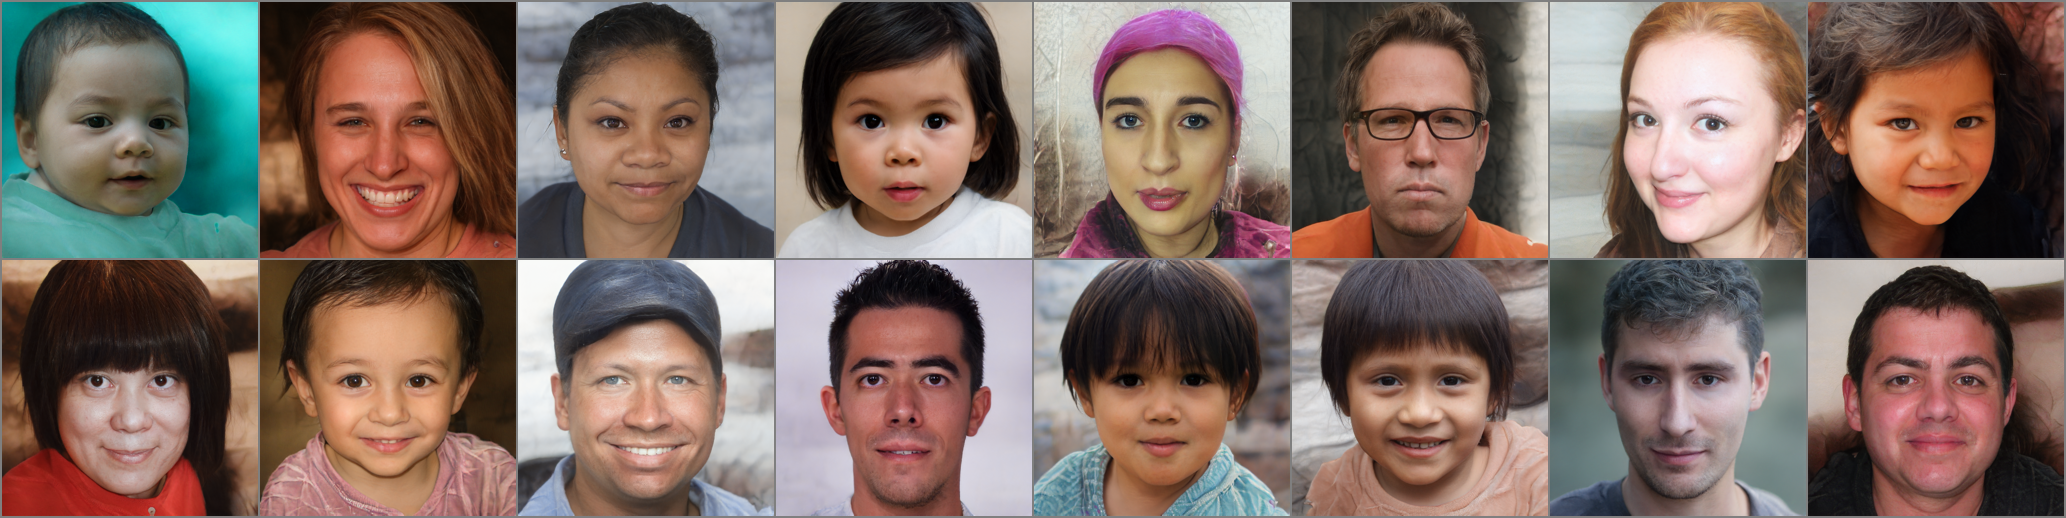

tensor([[    0.001,     0.006,     0.008],
        [    0.001,     0.002,     1.000],
        [    0.001,     0.037,     0.485],
        [    0.001,     0.001,     0.003],
        [    0.000,     0.027,     0.010],
        [    0.993,     0.933,     0.054],
        [    0.000,     0.000,     0.992],
        [    0.001,     0.052,     0.648],
        [    0.004,     0.016,     0.985],
        [    0.002,     0.071,     0.981],
        [    0.000,     0.992,     1.000],
        [    0.000,     1.000,     0.024],
        [    0.001,     0.013,     0.303],
        [    0.001,     0.039,     0.997],
        [    0.000,     0.999,     0.062],
        [    0.000,     1.000,     0.907]], device='cuda:3')

In [12]:
all_latents = torch.load('/home/zzhuang/AdaTrans/data/ffhq_train_latents.pth', map_location='cpu').cuda() + G.latent_avg
all_preds = torch.load('/home/zzhuang/AdaTrans/data/ffhq_train_preds.pth', map_location='cpu').cuda()
indices = torch.arange(16) + 0
display(to_pil_image(make_grid(G(all_latents[indices])).clamp(-1., 1.) * 0.5 + 0.5))
display(all_preds[indices[:, None], [15, 20, 31, ]])

In [15]:
from models.modules import FLOW
realnvp = FLOW(style_dim=G.style_dim, n_styles=G.n_styles, n_layer=10).cuda().eval()
optimizer = torch.optim.AdamW(list(realnvp.parameters()), lr=0.0001, weight_decay=0.00)
logger = LoggerX(save_root=None, print_freq=10)

max_iter = 10000
bs = 256

for n_iter in range(1, max_iter + 1):
    indices = torch.randint(0, len(all_latents), (bs, ))
    latents = all_latents[indices]
    realnvp.train()
    with torch.autograd.set_grad_enabled(True):
        loss, logz, log_det_jacobian, _ = realnvp(latents)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    logger.msg([logz, log_det_jacobian, loss], n_iter)

# realnvp.load_state_dict(torch.load('/home/zzhuang/NoisyGAN/models/infostyle/realnvp.pth', map_location='cpu'))

[2023-07-18 18:14:24] 00001, logz -1.45928, log_det_jacobian 303.13589, loss 0.86721, 
[2023-07-18 18:14:24] 00002, logz -1.45869, log_det_jacobian 305.92712, loss 0.86118, 
[2023-07-18 18:14:25] 00003, logz -1.45804, log_det_jacobian 307.22668, loss 0.85799, 
[2023-07-18 18:14:25] 00004, logz -1.45770, log_det_jacobian 312.75238, loss 0.84685, 
[2023-07-18 18:14:25] 00005, logz -1.45681, log_det_jacobian 315.00403, loss 0.84157, 
[2023-07-18 18:14:25] 00006, logz -1.45588, log_det_jacobian 314.46054, loss 0.84170, 
[2023-07-18 18:14:25] 00007, logz -1.45570, log_det_jacobian 314.38120, loss 0.84167, 
[2023-07-18 18:14:25] 00008, logz -1.45514, log_det_jacobian 322.82678, loss 0.82462, 
[2023-07-18 18:14:25] 00009, logz -1.45478, log_det_jacobian 313.19879, loss 0.84306, 
[2023-07-18 18:14:25] 00010, logz -1.45449, log_det_jacobian 318.30316, loss 0.83280, 
[2023-07-18 18:14:26] 00011, logz -1.45372, log_det_jacobian 318.99939, loss 0.83067, 
[2023-07-18 18:14:26] 00012, logz -1.45312,

KeyboardInterrupt: 

In [19]:
realnvp.load_state_dict(torch.load('/home/zzhuang/AdaTrans/data/realnvp.pth', map_location='cpu'))

<All keys matched successfully>

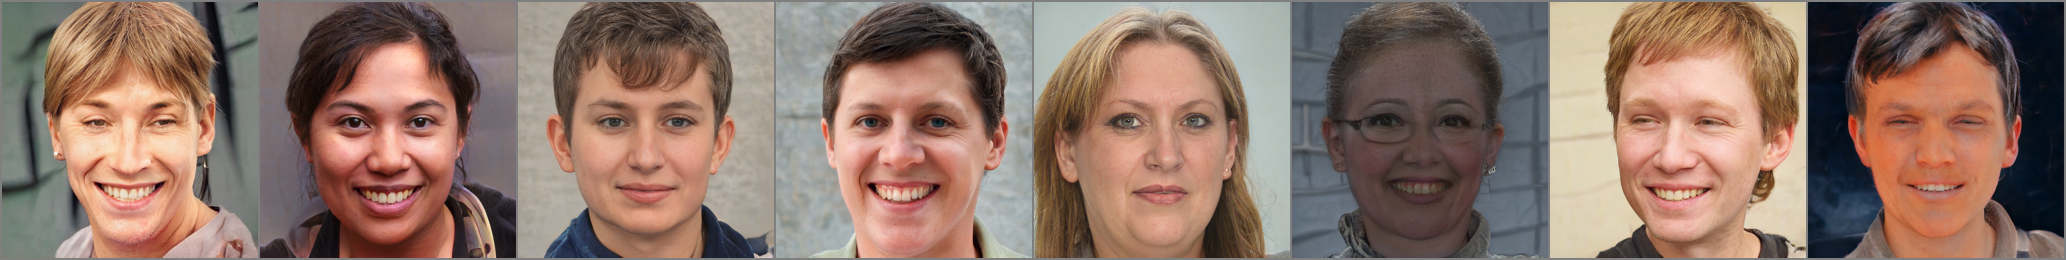

In [21]:
realnvp.eval()
to_pil_image(make_grid(G(realnvp.backward(torch.randn(8, G.n_styles, G.style_dim).cuda()).view(-1, G.n_styles, G.style_dim))).clamp(-1, 1) * 0.5 + 0.5)